External Source Performance Test (Default Rate)
H₀: Default rate is independent of external score group.
H₁: Default rate depends on external score group.
Chi-square: Statistic=8109.32, p=0.0000, df=1
Conclusion: Reject H₀; default rate depends on external score group.

Default Proportions by External Score Group:
TARGET            0         1
EXT_GROUP                    
<=0.5      0.875018  0.124982
>0.5       0.963525  0.036475


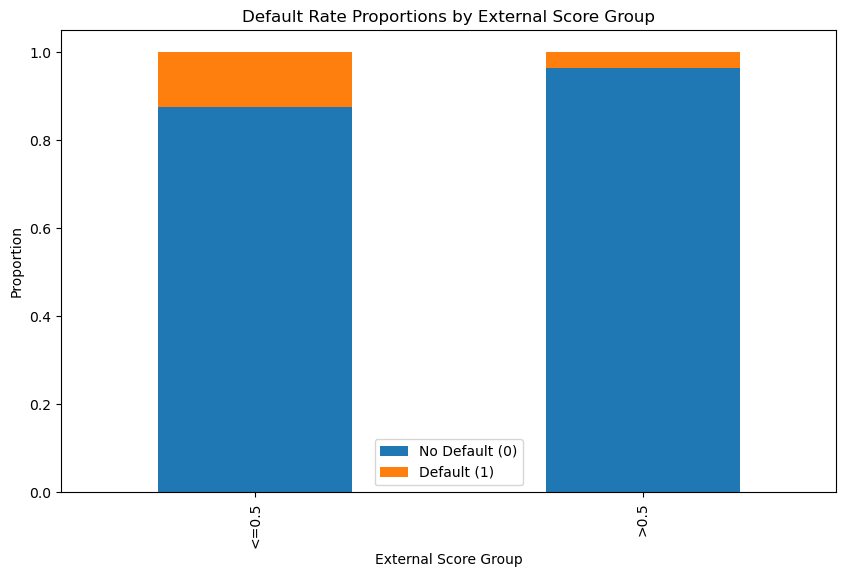

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv('application_train.csv')
df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)
df['EXT_GROUP'] = pd.qcut(df['EXT_SOURCES_MEAN'].rank(method='first'), 2, labels=['<=0.5', '>0.5'])

# Create contingency table
contingency_table = pd.crosstab(df['EXT_GROUP'], df['TARGET'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
alpha = 0.05
print("External Source Performance Test (Default Rate)")
print("H₀: Default rate is independent of external score group.")
print("H₁: Default rate depends on external score group.")
print(f"Chi-square: Statistic={chi2:.2f}, p={p:.4f}, df={dof}")
print("Conclusion:", "Reject H₀; default rate depends on external score group." if p < alpha else "Fail to reject H₀.")

# Proportion analysis
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print("\nDefault Proportions by External Score Group:")
print(proportions)

# Visualization
proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rate Proportions by External Score Group')
plt.xlabel('External Score Group')
plt.ylabel('Proportion')
plt.legend(['No Default (0)', 'Default (1)'])
plt.show()

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

# Load and clean data
df = pd.read_csv('application_train.csv')
df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)
df['EXT_GROUP'] = pd.qcut(df['EXT_SOURCES_MEAN'].rank(method='first'), 2, labels=['<=0.5', '>0.5'])
df['TARGET'] = pd.to_numeric(df['TARGET'], errors='coerce')

# === Assumption Checks ===
print("\n=== Logistic Regression Assumption Checks ===")
assumptions_met = True

# 1. Binary Outcome Check
unique_target = df['TARGET'].dropna().unique()
if set(unique_target).issubset({0, 1}):
    print("✅ TARGET is binary.")
else:
    print("❌ TARGET is not binary.")
    assumptions_met = False

# 2. Missing Values Check
missing_X = df['EXT_GROUP'].isnull().sum()
missing_y = df['TARGET'].isnull().sum()
if missing_X == 0 and missing_y == 0:
    print("✅ No missing values in EXT_GROUP or TARGET.")
else:
    print(f"⚠️ Missing values — EXT_GROUP: {missing_X}, TARGET: {missing_y}")
    assumptions_met = False

# 3. One-hot encode EXT_GROUP (drop first as baseline)
X_raw = pd.get_dummies(df['EXT_GROUP'], prefix='EXT', drop_first=True)
X_raw = sm.add_constant(X_raw)
X_clean = X_raw.apply(pd.to_numeric, errors='coerce')
y_clean = pd.to_numeric(df['TARGET'], errors='coerce')

# 4. Align and drop NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)
X_final = X_clean.loc[valid_index].astype(float)
y_final = y_clean.loc[valid_index].astype(float)

# 5. Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

if vif_data["VIF"].max() < 5:
    print("✅ No severe multicollinearity detected.")
else:
    print("⚠️ High VIF values detected. Consider dropping or combining correlated features.")
    assumptions_met = False

# 6. Sample Size Check
min_class_count = y_final.value_counts().min()
num_predictors = X_final.shape[1] - 1  # exclude constant
if min_class_count >= 10 * num_predictors:
    print(f"✅ Sample size is sufficient: {min_class_count} cases in minority class for {num_predictors} predictors.")
else:
    print(f"❌ Sample size may be insufficient: {min_class_count} cases for {num_predictors} predictors.")
    assumptions_met = False

# 7. Linearity of Log-Odds (Placeholder)
print("ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.")

# Final decision
if assumptions_met:
    print("\n✅ All key assumptions are met. Proceeding with logistic regression...\n")
else:
    print("\n❌ One or more assumptions not met. Review before proceeding with logistic regression.\n")

# === Fit Logistic Regression ===
model = sm.Logit(y_final, X_final).fit()

# === Detect true baseline category ===
all_categories = sorted(df['EXT_GROUP'].dropna().unique())
dummy_categories = [col.replace('EXT_', '') for col in X_final.columns if col.startswith('EXT_')]
baseline_ext_group = list(set(all_categories) - set(dummy_categories))[0]

# === Logistic Regression Summary ===
print("\n=== Logistic Regression for Loan Default Risk ===")
print(model.summary())

# === Business-Friendly Interpretations ===
print("\n=== Business-Friendly Interpretations ===")
intercept = model.params['const']
baseline_odds = np.exp(intercept)
print(f"Baseline ({baseline_ext_group} external score): log-odds = {intercept:.4f}, odds of default = {baseline_odds:.4f}")

# Model equation
equation_terms = [f"{model.params[col]:+.4f}·{col}" for col in X_final.columns[1:]]
equation = f"log(p / (1 - p)) = {intercept:.4f} " + " ".join(equation_terms)
print(f"\nModel Equation:\n{equation}")

for col in X_final.columns[1:]:
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    direction = "increases" if coef > 0 else "reduces"
    magnitude = (odds_ratio - 1) * 100 if coef > 0 else (1 - odds_ratio) * 100
    ext_group = col.replace('EXT_', '')
    print(f"\n{ext_group} vs baseline ({baseline_ext_group} external score):")
    print(f"- Coefficient: {coef:.4f}")
    print(f"- Odds Ratio: {odds_ratio:.3f}")
    print(f"- Interpretation: {ext_group} score group {direction} odds of default by {abs(magnitude):.1f}% compared to {baseline_ext_group}.")
    print(f"- Strategy: {'Apply caution' if coef > 0 else 'Prioritize'} {ext_group} score group applicants in approval and pricing.")

# ============================================
# 1. Default Proportions Dataset
# ============================================
contingency_table = pd.crosstab(df['EXT_GROUP'], df['TARGET'])
default_props_df = (
    contingency_table
    .div(contingency_table.sum(axis=1), axis=0)[1]
    .reset_index()
    .rename(columns={1: 'Default %'})
)
default_props_df['Default %'] = (default_props_df['Default %'] * 100).round(2)

print("\n=== Default Proportions Dataset ===")
print(default_props_df)

# ============================================
# 2. Logistic Regression Summary Dataset
# ============================================
logit_summary_rows = [{
    'External Score Group': baseline_ext_group,
    'Coefficient': None,
    'Odds Ratio': None,
    'Change vs Baseline': 'Baseline',
    'Baseline Odds of Default': round(baseline_odds, 4)
}]

for col in X_final.columns[1:]:
    ext_group = col.replace('EXT_', '')
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    pct_change = (odds_ratio - 1) * 100
    logit_summary_rows.append({
        'External Score Group': ext_group,
        'Coefficient': round(coef, 4),
        'Odds Ratio': round(odds_ratio, 3),
        'Change vs Baseline': f"{pct_change:.1f}%",
        'Baseline Odds of Default': None
    })

logit_summary_df = pd.DataFrame(logit_summary_rows)

print("\n=== Logistic Regression Summary Dataset ===")
print(logit_summary_df)

# ============================================
# Optional: Export for Power BI
# ============================================
default_props_df.to_csv("results/default_proportions_external_score_performance.csv", index=False)
logit_summary_df.to_csv("results/logistic_regression_summary_external_score_performance.csv", index=False)



=== Logistic Regression Assumption Checks ===
✅ TARGET is binary.
⚠️ Missing values — EXT_GROUP: 172, TARGET: 0

Variance Inflation Factor (VIF):
    Feature       VIF
0     const  1.998875
1  EXT_>0.5  1.000000
✅ No severe multicollinearity detected.
✅ Sample size is sufficient: 24825 cases in minority class for 1 predictors.
ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.

❌ One or more assumptions not met. Review before proceeding with logistic regression.

Optimization terminated successfully.
         Current function value: 0.266669
         Iterations 7

=== Logistic Regression for Loan Default Risk ===
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               307511
Model:                          Logit   Df Residuals:                   307509
Method:                           MLE   Df Model:                            1
Date:         

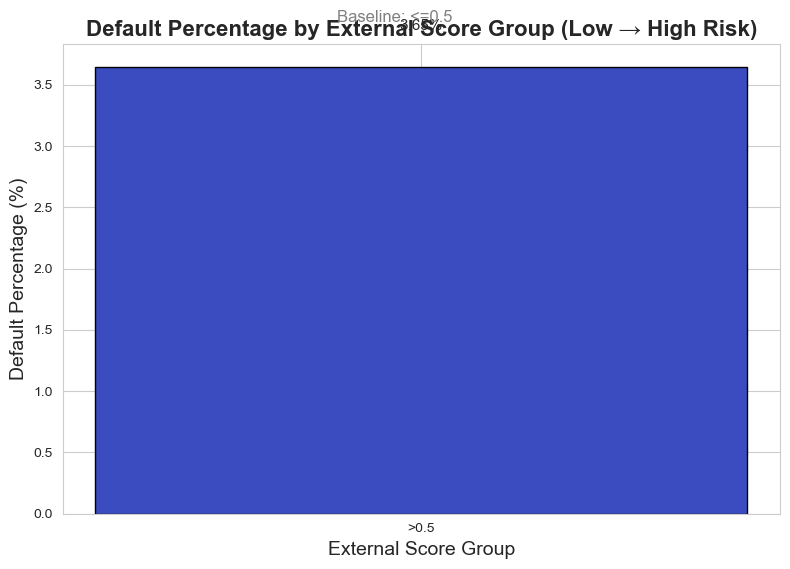

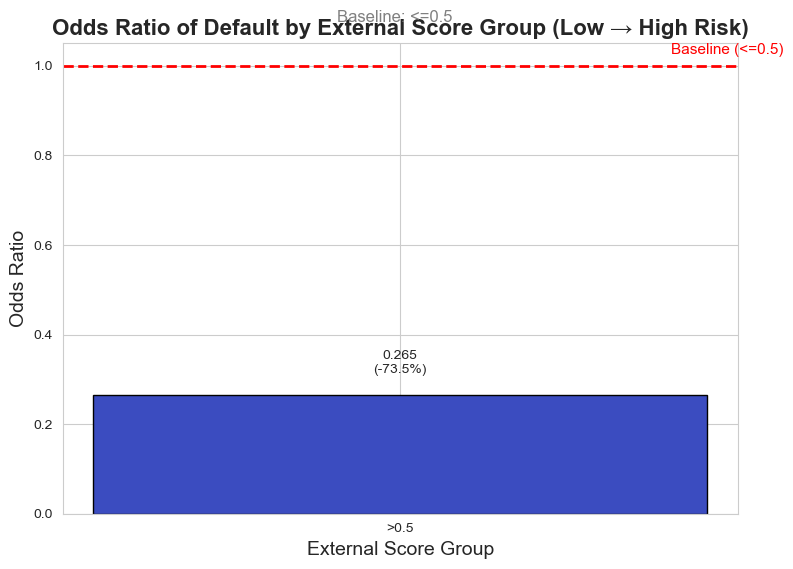

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
ext_order = odds_sorted['External Score Group'].tolist()

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered = default_props_ordered.set_index('EXT_GROUP').loc[ext_order].reset_index()
default_props_ordered.rename(columns={'EXT_GROUP': 'External Score Group'}, inplace=True)

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart
# ==============================
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['External Score Group'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Highlight baseline
for bar, label in zip(bars, default_props_ordered['External Score Group']):
    if label == baseline_ext_group:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 "Baseline", ha='center', fontsize=10, fontweight='bold', color='black')

plt.title("Default Percentage by External Score Group (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline: {baseline_ext_group}", fontsize=12, color='gray', y=0.94)
plt.xlabel("External Score Group", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f"{height:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/ext_score_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart
# ==============================
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['External Score Group'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_ext_group})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by External Score Group (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline: {baseline_ext_group}", fontsize=12, color='gray', y=0.94)
plt.xlabel("External Score Group", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f"{height:.3f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/ext_score_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()



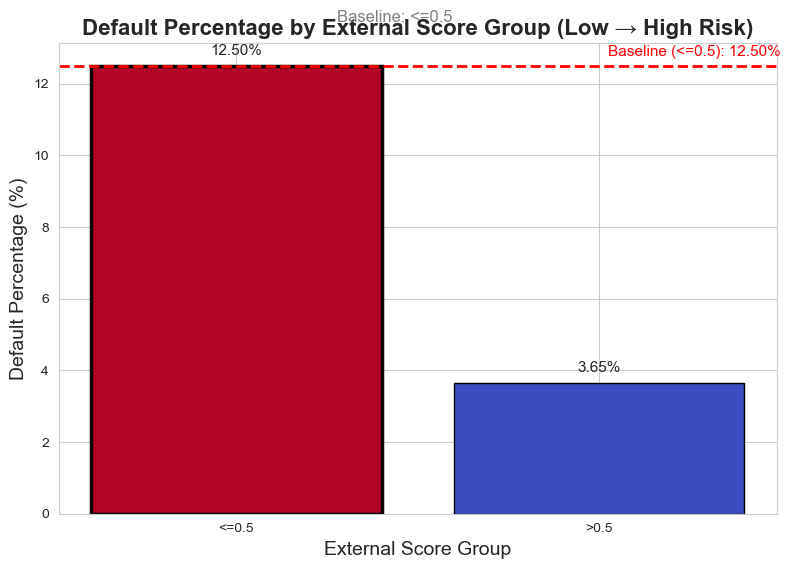

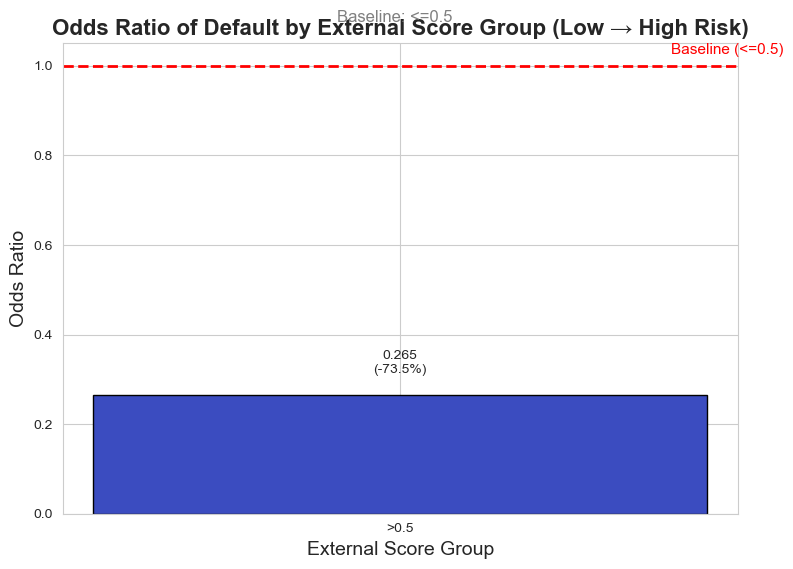

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio (low → high risk)
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
ext_order = odds_sorted['External Score Group'].tolist()

# Ensure baseline is in the order list
if baseline_ext_group not in ext_order:
    ext_order = [baseline_ext_group] + ext_order

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered = default_props_ordered.set_index('EXT_GROUP').loc[ext_order].reset_index()
default_props_ordered.rename(columns={'EXT_GROUP': 'External Score Group'}, inplace=True)

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (with baseline dashed line)
# ==============================
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['External Score Group'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Safely get baseline default percentage
mask = default_props_ordered['External Score Group'] == baseline_ext_group
if mask.any():
    baseline_value = default_props_ordered.loc[mask, 'Default %'].iloc[0]
    # Draw baseline dashed line + label
    plt.axhline(baseline_value, color='red', linestyle='--', linewidth=2)
    plt.text(len(default_props_ordered)-0.5, baseline_value + 0.2,
             f"Baseline ({baseline_ext_group}): {baseline_value:.2f}%",
             color='red', fontsize=11, va='bottom', ha='right')

# Highlight baseline bar
for bar, label in zip(bars, default_props_ordered['External Score Group']):
    if label == baseline_ext_group:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')

# Titles & labels
plt.title("Default Percentage by External Score Group (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline: {baseline_ext_group}", fontsize=12, color='gray', y=0.94)
plt.xlabel("External Score Group", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.3, f"{h:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/ext_score_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart (with baseline dashed line at 1.0)
# ==============================
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['External Score Group'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_ext_group})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by External Score Group (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline: {baseline_ext_group}", fontsize=12, color='gray', y=0.94)
plt.xlabel("External Score Group", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.3f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/ext_score_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()
